In [89]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal 

print("Setup Complete")

Setup Complete


In [90]:
ppg_filepath = "../golden_data/ppg_golden_data.csv"

ppg_data = pd.read_csv(ppg_filepath, nrows=50000)

In [113]:
# Định nghĩa các tham số
fs = 100.0  # Tần số lấy mẫu, ví dụ 50 Hz
lowcut = 0.5  # Tần số cắt thấp, 0.5 Hz
highcut = 5.0  # Tần số cắt cao, 5 Hz
order = 4  # Bậc của bộ lọc

# Hàm tính toán hệ số bộ lọc Butterworth trong miền tần số liên tục (s-domain)
def butter_bandpass_s(lowcut, highcut, fs, order=4):
    # Các cực của bộ lọc Butterworth
    poles = []

    pole = complex(-0.38268343, 0.9238795335)
    poles.append(pole)

    pole = complex(-0.38268343, -0.9238795335)
    poles.append(pole)

    pole = complex(-0.923879535, 0.3826834264)
    poles.append(pole)

    pole = complex(-0.923879535, -0.3826834264)
    poles.append(pole)
    
    # Các hệ số trong miền s
    b = [0, 0, 0, 0, 14641] 
    a = [1, 28.74438523, 413.1198405, 3478.070613, 14641]

    #a = np.poly(poles)
    #b = [0, 0, 0, 0, 1]
    return b, a

def bilinear_transform(b, a, fs):
    
    # Chuẩn hóa các hệ số
    #b_z = [0, 4.1449e-10, 4.5356e-09, 4.5120e-09, 4.0805e-10]
    #a_z = [1, -3.9739, 5.9219, -3.9223, 0.9742]

    b_z = [0, 5.7580e-06, 5.9773e-05, 5.6433e-05, 4.8459e-06]
    a_z = [1, -3.7128, 5.1789, -3.2162, 0.7502]
    
    return b_z, a_z

# Hàm lọc tín hiệu sử dụng các hệ số z-domain
def apply_filter(data, b, a):
    data = np.asarray(data, dtype=np.float64)  # Đảm bảo dữ liệu đầu vào là kiểu float64
    y = np.zeros_like(data, dtype=np.float64)  # Tạo mảng kết quả kiểu float64
    for i in range(len(data)):
        y[i] = b[0] * data[i]
        for j in range(1, len(b)):
            if i-j >= 0:
                y[i] += b[j] * data[i-j]
        for j in range(1, len(a)):
            if i-j >= 0:
                y[i] -= a[j] * y[i-j]
    return y


In [114]:

b_s, a_s = butter_bandpass_s(lowcut, highcut, fs, order)
print(a_s)
print(b_s)

# Chuyển đổi các hệ số từ miền s sang miền z
b_z, a_z = bilinear_transform(b_s, a_s, fs)
print(a_z)
print(b_z)

# Áp dụng bộ lọc
filtered_sig = apply_filter(ppg_data, b_z, a_z)

[1, 28.74438523, 413.1198405, 3478.070613, 14641]
[0, 0, 0, 0, 14641]
[1, -3.7128, 5.1789, -3.2162, 0.7502]
[0, 5.758e-06, 5.9773e-05, 5.6433e-05, 4.8459e-06]


In [115]:
print(filtered_sig)

[[0.00000000e+00]
 [5.64859800e-03]
 [8.52752997e-02]
 ...
 [1.16053108e+03]
 [1.16274357e+03]
 [1.16500674e+03]]


<Axes: >

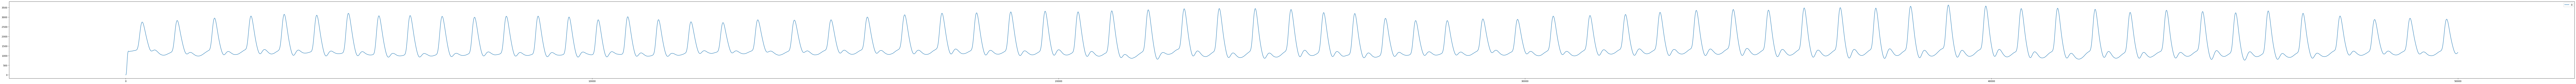

In [116]:
# Hiển thị tín hiệu trước và sau khi lọc
plt.figure(figsize=(200,6))
sns.lineplot(data=filtered_sig)